## 作業

1. 如何使用已經訓練好的模型？
2. 依照 https://github.com/qqwweee/keras-yolo3 的程式碼，請敘述，訓練模型時，資料集的格式是什麼？具體一點的說，要提供什麼格式的文件來描述資料集的圖片以及 bboxes 的信息呢？





In [ ]:
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

In [ ]:
# pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

In [ ]:
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# # 下載基於 keras 的 yolov3 程式碼
# %cd 'gdrive/My Drive'
# # !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
# %cd keras-yolo3

In [ ]:
from PIL import Image
image = Image.open('dog.jpg') 

## 產生 VOC Annotation
* 產生三個檔案，2007_train.txt, 2007_trainval.txt 和 test.txt
* 內容格式為: image_path,x1,y1,x2,y2,class_id

In [17]:
import xml.etree.ElementTree as ET
from os import getcwd

sets=[('2007', 'train'), ('2007', 'trainval'), ('2007', 'val')]

classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]


def convert_annotation(year, image_id, list_file):
    in_file = open('dataset/VOCdevkit/VOC%s/Annotations/%s.xml'%(year, image_id))
    tree=ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

wd = getcwd()

for year, image_set in sets:
    image_ids = open('dataset/VOCdevkit/VOC%s/ImageSets/Segmentation/%s.txt'%(year, image_set)).read().strip().split()
    print("{}{}.txt = {} images".format(year, image_set, len(image_ids)))
    list_file = open('%s_%s.txt'%(year, image_set), 'w')
    for image_id in image_ids:
        list_file.write('%s/dataset/VOCdevkit/VOC%s/JPEGImages/%s.jpg'%(wd, year, image_id))
        convert_annotation(year, image_id, list_file)
        list_file.write('\n')
    list_file.close()

2007train.txt = 209
2007trainval.txt = 422
2007val.txt = 213


## 把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重
* python convert.py -w yolov3.cfg model_data/yolov3.weights model_data/yolo_weights_ony.h5
* python convert.py -w yolov3-tiny.cfg model_data/yolov3-tiny.weights model_data/yolo_weights_only.h5

## 訓練 YOLO 模型 

In [18]:
"""
Retrain the YOLO model for your own dataset.
"""

import os 
import sys
# 將 yolo3 加入 path
module_path = os.getcwd()+ "/keras-yolo3"
if module_path not in sys.path:
    sys.path.append(module_path)
    

import warnings   
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)    
    
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data


In [19]:

def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)


def create_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='keras-yolo3/model_data/yolo_weights.h5'):
    '''create the training model'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})([*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

def create_tiny_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/tiny_yolo_weights.h5'):
    '''create the training model, for Tiny YOLOv3'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16}[l], w//{0:32, 1:16}[l], \
        num_anchors//2, num_classes+5)) for l in range(2)]

    model_body = tiny_yolo_body(image_input, num_anchors//2, num_classes)
    print('Create Tiny YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze the darknet body or freeze all but 2 output layers.
            num = (20, len(model_body.layers)-2)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.7})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)

In [20]:

# Main Program

def _main():
    annotation_path = '2007_trainval.txt'
    log_dir = 'keras-yolo3/logs/000/'
    classes_path = 'keras-yolo3/model_data/voc_classes.txt'
    
    # yolov3 propose 3 anchors for each grid
    # tiny anchors= 6 anchors, yolo anchors =9
    # anchor mask decides whihc anchors are used 
    anchors_path = 'keras-yolo3/model_data/tiny_yolo_anchors.txt'   
    
    class_names = get_classes(classes_path)
    num_classes = len(class_names)
    anchors = get_anchors(anchors_path)
    batch_size = 32 # note that more GPU memory is required after unfreezing the body
    epochs=(20,30)  # 0:epochs[0] for frozen layers, epochs[0]:epochs[1] for all layers  

    

    input_shape = (416,416) # multiple of 32, hw

    is_tiny_version = len(anchors)==6 # default setting
    if is_tiny_version:
        model = create_tiny_model(input_shape, anchors, num_classes,
            freeze_body=2, weights_path='keras-yolo3/model_data/tiny_yolo_weights_only.h5')
    else:
        model = create_model(input_shape, anchors, num_classes,
            freeze_body=2, weights_path='keras-yolo3/model_data/yolo_weights_only.h5') # make sure you know what you freeze

    logging = TensorBoard(log_dir=log_dir)
    checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
        monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

    val_split = 0.1
    with open(annotation_path) as f:
        lines = f.readlines()
    np.random.seed(10101)
    np.random.shuffle(lines)
    np.random.seed(None)
    num_val = int(len(lines)*val_split)  # 10% validation, 90% training
    num_train = len(lines) - num_val

    # Train with frozen layers first, to get a stable loss.
    # Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
    if True:
        model.compile(optimizer=Adam(lr=1e-3), loss={
            # use custom yolo_loss Lambda layer.
            'yolo_loss': lambda y_true, y_pred: y_pred})

#         batch_size = 32
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
                steps_per_epoch=max(1, num_train//batch_size),
                validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
                validation_steps=max(1, num_val//batch_size),
                epochs=epochs[0],
                initial_epoch=0,
                callbacks=[logging, checkpoint])
        model.save_weights(log_dir + 'trained_weights_stage_1.h5')

    # Unfreeze and continue training, to fine-tune.
    # Train longer if the result is not good.
    if True:
        for i in range(len(model.layers)):
            model.layers[i].trainable = True
        model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
        print('Unfreeze all of the layers.')


        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=epochs[1],
            initial_epoch=epochs[0],
            callbacks=[logging, checkpoint, reduce_lr, early_stopping])
        model.save_weights(log_dir + 'trained_weights_final.h5')

    # Further training if needed.



if __name__ == '__main__':
    _main()


Create Tiny YOLOv3 model with 6 anchors and 20 classes.


/home/cicicici_hsiao/anaconda3/envs/cv100/lib/python3.7/site-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_10 due to mismatch in shape ((1, 1, 512, 75) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/home/cicicici_hsiao/anaconda3/envs/cv100/lib/python3.7/site-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_10 due to mismatch in shape ((75,) vs (255,)).
  weight_values[i].shape))
/home/cicicici_hsiao/anaconda3/envs/cv100/lib/python3.7/site-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_13 due to mismatch in shape ((1, 1, 256, 75) vs (255, 256, 1, 1)).
  weight_values[i].shape))
/home/cicicici_hsiao/anaconda3/envs/cv100/lib/python3.7/site-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_13 due to mismatch in shape ((75,) vs (255,)).
  weight_values[i].shape))


Load weights keras-yolo3/model_data/tiny_yolo_weights_only.h5.
Freeze the first 42 layers of total 44 layers.
Train on 380 samples, val on 42 samples, with batch size 32.
Epoch 1/20
11/11 [==============================] - 41s 4s/step - loss: 1003.9936 - val_loss: 539.0328
Epoch 2/20
11/11 [==============================] - 25s 2s/step - loss: 323.1064 - val_loss: 205.3240
Epoch 3/20
11/11 [==============================] - 25s 2s/step - loss: 154.6224 - val_loss: 146.1839
Epoch 4/20
11/11 [==============================] - 24s 2s/step - loss: 104.3367 - val_loss: 99.4997
Epoch 5/20
11/11 [==============================] - 25s 2s/step - loss: 80.9000 - val_loss: 85.4596
Epoch 6/20
11/11 [==============================] - 26s 2s/step - loss: 71.7359 - val_loss: 73.1033
Epoch 7/20
11/11 [==============================] - 26s 2s/step - loss: 64.2795 - val_loss: 62.6779
Epoch 8/20
11/11 [==============================] - 25s 2s/step - loss: 59.1667 - val_loss: 67.1751
Epoch 9/20
11/11 [===

## Output YOLOv3 model diagram

In [8]:
from keras.utils import plot_model

classes_path = 'keras-yolo3/model_data/voc_classes.txt'
# anchors_path = 'keras-yolo3/model_data/yolo_anchors.txt'  
anchors_path = 'keras-yolo3/model_data/tiny_yolo_anchors.txt'  
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)


input_shape = (416,416) # multiple of 32, hw
# model = create_model(input_shape, anchors, num_classes,
#             freeze_body=2, weights_path='keras-yolo3/model_data/yolo_weights_only.h5')

model = create_tiny_model(input_shape, anchors, num_classes,
            freeze_body=2, weights_path='keras-yolo3/model_data/tiny_yolo_weights_only.h5')

plot_model(model, to_file='yolo3_model.png')

Create Tiny YOLOv3 model with 6 anchors and 20 classes.


/home/cicicici_hsiao/anaconda3/envs/cv100/lib/python3.7/site-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_10 due to mismatch in shape ((1, 1, 512, 75) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/home/cicicici_hsiao/anaconda3/envs/cv100/lib/python3.7/site-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_10 due to mismatch in shape ((75,) vs (255,)).
  weight_values[i].shape))
/home/cicicici_hsiao/anaconda3/envs/cv100/lib/python3.7/site-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_13 due to mismatch in shape ((1, 1, 256, 75) vs (255, 256, 1, 1)).
  weight_values[i].shape))
/home/cicicici_hsiao/anaconda3/envs/cv100/lib/python3.7/site-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_13 due to mismatch in shape ((75,) vs (255,)).
  weight_values[i].shape))


Load weights keras-yolo3/model_data/tiny_yolo_weights_only.h5.
Freeze the first 42 layers of total 44 layers.


## 測試新訓練模型

keras-yolo3/logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 2 boxes for img
dog 0.31 (88, 229) (366, 560)
car 0.44 (360, 92) (764, 161)
0.8578137280001101


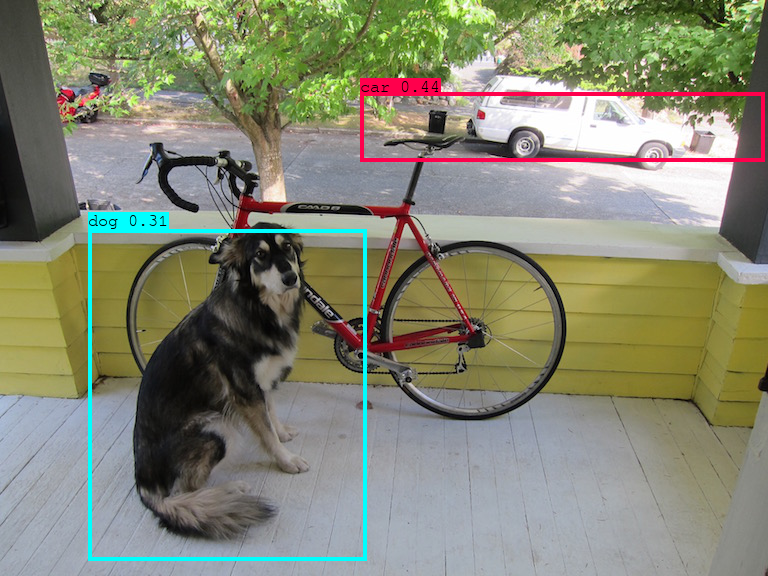

In [21]:
from yolo import YOLO
from PIL import Image

im = Image.open('dog.jpg') 

# voc2007 imageset 
d = {
        "model_path": 'keras-yolo3/logs/000/trained_weights_final.h5',
        "anchors_path": 'keras-yolo3/model_data/tiny_yolo_anchors.txt',
        "classes_path": 'keras-yolo3/model_data/voc_classes.txt',
    }


voc2007_yolo = YOLO(**d) 
voc2007_yolo.detect_image(im)
